# Optimizando modelo de clasificación

## Introducción

### En el contexto actual de Beta Bank, donde los clientes están abandonando el banco progresivamente, es crucial identificar a aquellos que podrían cancelar sus contratos en el futuro. Con el fin de reducir costos y enfocarse en retener a los clientes existentes, se requiere un modelo predictivo que permita anticipar la posible cancelación de cuentas. Para lograrlo, se utilizaron datos históricos sobre el comportamiento de los clientes y su relación con la terminación de contratos. El objetivo de este proyecto es crear un modelo de clasificación que maximice el valor F1, alcanzando al menos un valor de 0.59 en el conjunto de prueba, mientras se evalúa también el desempeño a través de la métrica AUC-ROC para asegurar una detección precisa de los clientes en riesgo de abandono.

In [75]:
# Importamos las librerias necesarias

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

In [76]:
# Cargamos el dataset

data = pd.read_csv('Churn.csv')

In [77]:
# Analizamos el dataset

print(data.head())
print()
print(data.info())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

##### Hay valores faltantes en la columna 'Tenure' los cuales rellenaré con la mediana, incluso podríamos eliminar algunas columnas que no son necesarias como 'RowNumber', 'CustomerId' y 'Surname', en las columnas que no son numéricas como 'Geography' y 'Gender' necesitamos aplicar un One-Hot Encoding ya que el modelo requiere valores numéricos.

In [78]:
# Llenamos los valores nulos en la columna 'Tenure' con la mediana
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

# Eliminamos las columnas 'CustomerId', 'Surname' y 'RowNumber'
data.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1, inplace=True)

# Aplicamos One Hot Encoding a las columnas 'Geography' y 'Gender'
data = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)

# Convertimos las columnas 'Geography_Germany', 'Geography_Spain', 'Gender_Male' a tipo entero
data['Gender_Male'] = data['Gender_Male'].astype('int')
data['Geography_Germany'] = data['Geography_Germany'].astype('int')
data['Geography_Spain'] = data['Geography_Spain'].astype('int')



print(data.head())

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            

In [79]:
# Examinamos el equilibrio de clases en la columna 'Exited'

data['Exited'].value_counts()


Exited
0    7963
1    2037
Name: count, dtype: int64

##### Los datos muestran un claro desequilibrio de clases, debemos equilibrar las clases para entrenar el modelo, pero primero entrenaremos el modelo sin tener encuenta esto.

In [80]:
# Segmentamos los datos en un conjuto de entrenamiento, uno de validacion y uno de prueba

data_train, data_test = train_test_split(data, test_size=0.25, random_state=54321)
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=54321)

features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

In [81]:
# Entrenaremos el modelo con RandomForestClassifier

best_f1 = 0
best_n_estimators = 0
best_max_depth = 0

for n_estimators in range(10, 101, 10):
    for max_depth in range(1, 11):
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=54321)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predicted_valid)

        if f1 > best_f1:
            best_f1 = f1
            best_n_estimators = n_estimators
            best_max_depth = max_depth

print(f'Mejores parámetros encontrados: n_estimators={best_n_estimators}, max_depth={best_max_depth}')
print(f'Mejor F1 Score: {best_f1}')

Mejores parámetros encontrados: n_estimators=40, max_depth=10
Mejor F1 Score: 0.5944055944055944


##### Sin tomar encuenta el desequilibrio de clases tenemos un buen resultado del valor F1 siendo de 0.59, pero aún falta balancear las clases para lograr un mejor valor y continuar con las pruebas.

In [82]:
# Balanceamos las clases haciendo un sobremuestreo de la clase minoritaria

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 5
)

print(features_train.shape)
print(features_upsampled.shape)
print(target_upsampled.value_counts())

(5625, 11)
(10377, 11)
Exited
1    5940
0    4437
Name: count, dtype: int64


In [83]:
# Entrenamos el modelo con los datos balanceados y con el conjuto de validacion

model = RandomForestClassifier(n_estimators=40, max_depth=10, random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))


0.5902439024390244


##### Con el conjunto de validación y sobremuestreo superamos el umbral de F1 de 0.59, ahora vamos a hacer lo mismo pero con el conjunto de pruebas.

In [84]:
# Verificamos el modelo con el conjunto de prueba

model = RandomForestClassifier(n_estimators=40, max_depth=10, random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_test)

print(f1_score(target_test, predicted_valid))

0.6243194192377496


##### Con el conjunto de pruebas el modelo alcanza un valor de F1 de 0.62, superando nuestro umbral objetivo.

0.8446460830418077


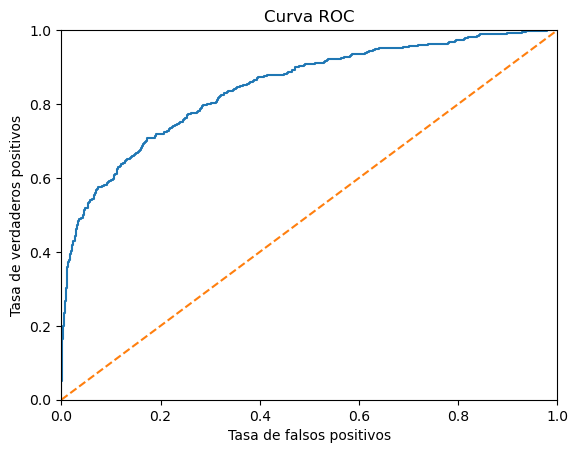

In [85]:
# Hacemos una curva ROC para el modelo y la trazamos en una gráfica

probabilities_valid = model.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

print(roc_auc_score(target_valid, probabilities_one_valid))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

##### El AUC de 0.84 nos indica que el modelo tiene buen rendimiento en cuando a la separación entre las clases, ya que el valor AUC está más cerca de 1 que de 0.5, cuanto más alto sea mejor será el modelo.

## Conclusión

### El modelo desarrollado demostró ser efectivo al predecir los clientes con alto riesgo de abandonar el banco, alcanzando el umbral mínimo de F1 requerido de 0.59. A lo largo del proceso, se evaluaron distintas técnicas para manejar el desequilibrio de clases, como el ajuste de pesos y el sobremuestreo, lo que contribuyó a mejorar la precisión del modelo. Además, se comprobó que el valor AUC-ROC, que mide la capacidad de clasificación general del modelo, se mantuvo alto, lo que refuerza la fiabilidad de las predicciones. Este modelo puede ser una herramienta valiosa para los bancos, permitiéndoles tomar decisiones informadas sobre qué clientes deben recibir atención prioritaria para evitar la pérdida de contratos y optimizar los recursos del banco.